# Exploring MNIST AutoEncoder with T-SNE
----

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
from mnist_ae import *

import torch
from torch.utils.data import DataLoader
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
MAE = MNIST_AE(r"/mnt/data/data/", r"/mnt/data/train_camp/mnist_ae", device=dev)

In [3]:
MAE.load_last_model()

{'epoch': 9, 'num_epoch': 10}

In [4]:
# get the test data sete
mnist_data = tv.datasets.MNIST(
    root=r"/mnt/data/data/",
    train=False,
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5], [0.5])
    ])
)
print(f"There are {len(mnist_data)} test samples")

There are 10000 test samples


## Test with 5 randomly selected images
----

In [5]:
# randomly select 5 test samples

# I don't know how to get directly all 5
images = torch.zeros(5,1,28,28, device=dev)
labels = []

idx = np.random.choice(len(mnist_data), 5)
for i in range(len(idx)):
    test_data = mnist_data[idx[i]]
    images[i,:,:,:] = test_data[0]
    labels.append(test_data[1])

In [6]:
MAE.model.eval()
recon = MAE.model(images)

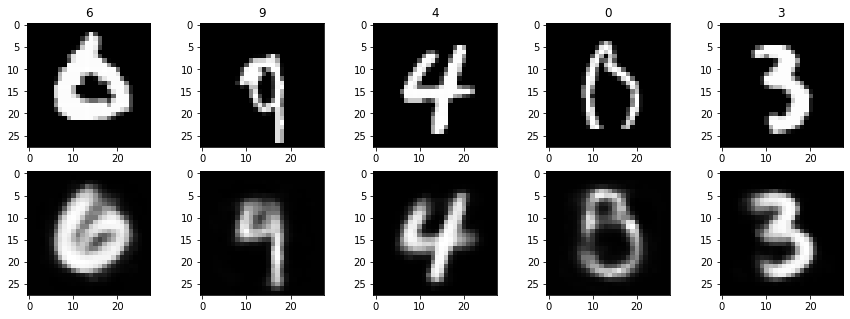

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
for i in range(5):
    ax[0, i].imshow(images[i,0,:,:].cpu().detach().numpy(), cmap=plt.cm.gray)
    ax[0, i].set_title(f"{labels[i]}")
    
    ax[1, i].imshow(recon[i,0,:,:].cpu().detach().numpy(), cmap=plt.cm.gray)

## T-SNE of the original images
----

In [23]:
# get the training data
test_img = np.zeros((len(mnist_data), 28*28))
test_label = np.zeros(len(mnist_data), dtype=np.int)

# get every 100, then copy to Z
test_gen = DataLoader(mnist_data, batch_size=100)
for i, dt in enumerate(test_gen):
    offset = i*100
    test_label[offset:(offset+100)] = dt[1]
    test_img[offset:(offset+100), :] = dt[0].view((100, 28*28)).cpu().numpy()

In [24]:
tsne = TSNE(n_components=2)
y_ori = tsne.fit_transform(test_img, test_label)

<AxesSubplot:>

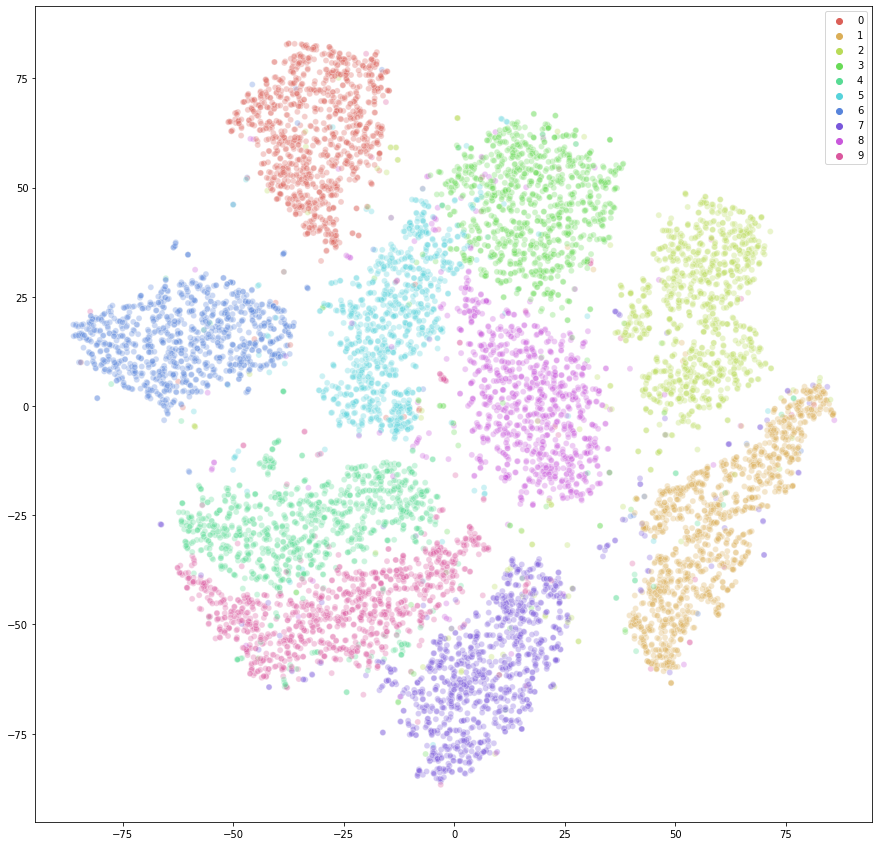

In [25]:
plt.figure(figsize=(15,15))
sns.scatterplot(
    x=y_ori[:,0],
    y=y_ori[:,1],
    hue=test_label,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

## T-SNE with ENCODER

In [26]:
encoder = MAE.model.encoder

In [28]:
encoder[-2]

Linear(in_features=32, out_features=16, bias=True)

In [43]:
test_latent = np.zeros((len(mnist_data), 16))

encoder.eval()
for i, dt in enumerate(test_gen):
    offset = i*100
    y = dt[0].to(MAE.device).view((100, 28*28))
    for e in encoder:
        y = e(y)
    
    test_latent[offset:(offset+100),:] = y.cpu().detach().numpy()

In [44]:
y_latent = tsne.fit_transform(test_latent, test_label)

<AxesSubplot:>

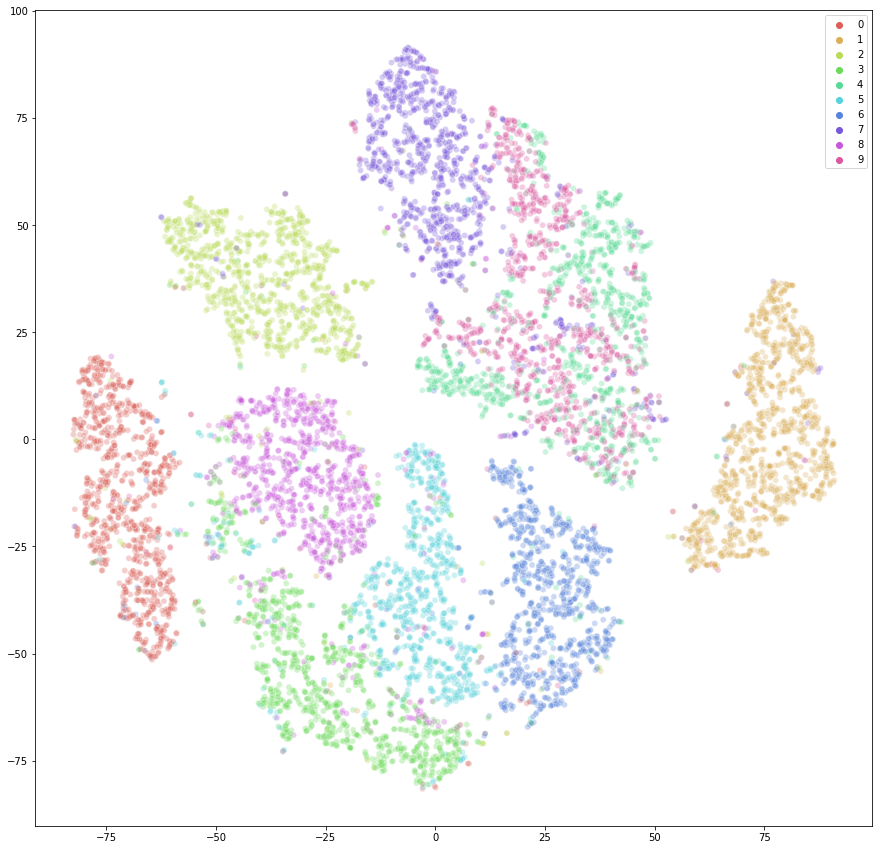

In [45]:
plt.figure(figsize=(15,15))
sns.scatterplot(
    x=y_latent[:,0],
    y=y_latent[:,1],
    hue=test_label,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)